# Introduction

In this tutorial we will go through a full cycle of model tuning and evaluation with Polara. This will include 2 phases: grid-search for finding  (almost) optimal values of hyper-parameters and verification of results via 5-fold cross-validation.

<div class="alert alert-block alert-info">We will focus on performing a fair comparison of popular ALS-based matrix factorization (MF) model called Weighted Regularized Matrix Factorization (WRMF a.k.a. iALS) [Hu2008] with less popular model called PureSVD [Cremonesi2010] based on standard SVD.</div>

We will use standard *Scipy*'s implementation for the latter and a great library called [*implicit*](https://github.com/benfred/implicit) for iALS. Both are wrapped by Polara and can be accessed via the corresponding classes. Due to its practicality the *implicit* library is often recommended to beginners and sometimes even serves as a default tool in production. On the other hand, there are some important yet often overlooked features, which make SVD-based models stand out. Ignoring them in my opinion leads to certain misconceptions and myths, not to say that it also overcomplicates things quite a bit.

Note that by saying SVD I really mean *Singular Value Decomposition*, not just an arbitrary matrix factorization. In that sense, **methods like FunkSVD, SVD++, SVDFeature, etc., are not SVD-based at all**, even though historically they use SVD acronym in their names and are often referenced as if they are real substitutes for SVD. These methods utilize another optimization algorithm, typically based on stochastic gradient descent, and do not preserve the algebraic properties of SVD. This is really an important distinction, especially in the view of the following remarks:

1. **SVD-based approach has a number of unique and beneficial properties**. To name a few, it produces stable and determenistic output with global guarantees. It admits the same prediction formula for both known and previously unseen users (as long as at least one user rating is known). It can take a hybrid form to include side information via the generalized formulation (see Chapter 6 of [my thesis](https://www.skoltech.ru/en/2018/09/phd-thesis-defense-evgeny-frolov)). Even without hybridization it can be quite successfully applied in the cold start regime (paper on this is coming). It requires minimal tuning and allows to compute and store a single latent feature matrix - either for users or for items - instead of computing and storing both of them. This luxury is not available in the majority of other matrix factorization approaches, definitely not in popular ones.  
2. Computational complexity of truncated SVD **scales linearly with the number of known observations** and quadratically with the rank of decomposition (thanks to Lanczos procedure). There are [open source implementations](https://github.com/criteo/rsvd), allowing to handle in a distributed manner nearly *billion-scale problems* with its [efficient randomized version](https://medium.com/criteo-labs/sparkrsvd-open-sourced-by-criteo-for-large-scale-recommendation-engines-6695b649f519).  
3. At least **in some cases PureSVD outperforms other more sophisticated matrix factorization methods** [Cremonesi2010].
4. Moreover, **PureSVD can be quite easily tuned to perform even better** [Nikolakopoulos2019].

Despite that impresisve list, PureSVD technique (and especially its modifications) rarely gets into the list of baseline models to compare with. Hence, this tutorial also aims at performing a thorough assessment of the default choice of many practitioners to see whether it really provides the celebrated advantages over the simpler approach.

## References

* [Hu 2008], Hu Y., Koren, Y. and Volinsky, C., 2008, December. *Collaborative Filtering for Implicit Feedback Datasets*. In ICDM (Vol. 8, pp. 263-272). [Link](http://yifanhu.net/PUB/cf.pdf).  
* [Cremonesi2010] Cremonesi, P., Koren, Y. and Turrin, R., 2010, September. *Performance of recommender algorithms on top-n recommendation tasks*. In Proceedings of the fourth ACM conference on Recommender systems (pp. 39-46). ACM. [Link](https://www.researchgate.net/publication/221141030_Performance_of_recommender_algorithms_on_top-N_recommendation_tasks).  
* [Nikolakopoulos2019] Nikolakopoulos, A.N., Kalantzis, V., Gallopoulos, E. and Garofalakis, J.D., 2019. *EigenRec: generalizing PureSVD for effective and efficient top-N recommendations*. Knowledge and Information Systems, 58(1), pp.59-81. [Link](https://arxiv.org/abs/1511.06033).

# Downloading data

We will use the **[Movielens-10M](https://grouplens.org/datasets/movielens/)** dataset for our experiments. It's large enough to perform reliable evaluation; however, not that large that you would spend too many hours waiting for results. If you don't plan to play with the code, you may want to run all cells with a single command and leave the notebook running in the background, while reading the text. It takes around 1.5h to complete this notebook on a modern laptop.

Note that you'll need an internet connection in order to run the code below. It will automatically download data, store it in a temporary location, and convert into a `pandas` dataframe.  
Alternatively, if you have already downloaded the dataset, you can use path to it as an input for the `get_movielens_data` function instead of `tmp_file`.

In [1]:
import urllib
from polara import (get_movielens_data, # returns data in the pandas dataframe format
                    RecommenderData) # provides common interface to access data 

In [2]:
url = 'http://files.grouplens.org/datasets/movielens/ml-10m.zip'
tmp_file, _ = urllib.request.urlretrieve(url) # this may take some time depending on your internet connection

data = get_movielens_data(tmp_file, include_time=True)
data.head()

,userid,movieid,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


The resulting dataframe has a bit more than 10M ratings, as expected.

In [3]:
data.shape

(10000054, 4)

Basic data stats:

In [4]:
data.apply('nunique')

userid         69878
movieid        10677
rating            10
timestamp    7096905
dtype: int64

# Preparing data

As always, you need to firstly define a data model that will provide a common interface for all recommendation algorithms used in experiments:

In [5]:
data_model = RecommenderData(data, 'userid', 'movieid', 'rating', custom_order='timestamp', seed=0)
data_model.fields

Fields(userid='userid', itemid='movieid', feedback='rating')

Setting `seed=0` ensures controllable randomization when sampling test data, which enhances reproducibility; `custom_order` allows to select observations for evaluation based on their timestamp, rather than on rating value (more on that later). 

Let's look at the default configuration of data model:

In [6]:
data_model.get_configuration()

{'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'permute_tops': False,
 'warm_start': True,
 'random_holdout': False,
 'negative_prediction': False,
 'test_sample': None,
 'holdout_size': 3}

By default, `Polara` samples 20% of users and marks them for test (`test_ratio` attribute). These users would be excluded from the training dataset, if `warm_start` attribute remained set to `True` (strong generalization test). However, in the iALS case such setting would require running additional half-step optimization (folding-in) for each test user in order to obtain their latent representation. To avoid that we turn the "warm start" setting off and perform standard evaluation (weak generalization test). In that case test users are part of the training (except for the ratings that were held out for evaluation) and one can directly invoke scalar products of latent factors. Note that *SVD recommendations do not depend on this setting due to uniform projection formula applicable to both known and "warm" users*: $r = VV^\top p$, where $r$ is a vector of predicted relevance scores, $p$ is a vector of *any* known preferences and $V$ is an item latent features matrix.

In [7]:
data_model.holdout_size = 1 # hold out 1 item from every test user
data_model.random_holdout = False # take items with the latest timstamp
data_model.warm_start = False # standard case
data_model.prepare()

Preparing data...
Done.
There are 9986078 events in the training and 13976 events in the holdout.


The `holdout_size` attribute controls how many user preferences will be used for evaluation. Current configuration instructs data model to holdout one item from every test user. The `random_holdout=False` setting along with `custom_order` input argumment of data model make sure that only the latest rated item is taken for evaluation, allowing to avoid "recommendations from future". All these items are available via `data_model.test.holdout`.

# General configuration

## technical settings

Sometimes due to the size of dataset evaluation make take considerably longer than actual training time. If that's the case, you may want to give Polara more resources to perform evaluation, which is mostly controlled by changing `memory_hard_limit` and `max_test_workers` settings from their defaults. The former defines how much memory is allowed to use when generating predictions for test users. Essentially, Polara avoids running an inefficient by-user-loop for that task and makes calculation in bulk, which allos to invoke linear algebra kernels and speed up calculations. This, however, generates dense $M \times N$ matrix, where $M$ is the number of test users and $N$ is the number of all items seen during training. If this matrix doesn't fit into the memory constraint defined by `memory_hard_limit` (1Gb by default), calculations will be perfomed on a sequence of groups of $m<M$ users so that each group respects the constraint. If you have enough resources it can be a good idea to increase this memory limit. However, depending on hardware specs, manipulating huge amount of test data can be also slow. In that case it can be useful to still split test users into smaller group, however run calculations on each group in parallel. This can be achieved by setting `max_test_workers` integer to some number above 0, which will spawn the corresponding number of parallel threads. For example, instead of generating 60Gb matrix in a single run, one can define `memory_hard_limit=15` and `max_test_workers=4`, which may help complete calculations faster.

In our case simply increasing the memory limit to 2Gb is sufficient for optimal performance.

In [8]:
from polara.recommender import defaults

In [9]:
defaults.memory_hard_limit = 2
defaults.max_test_workers = None # None is the default value

## common config

#### evaluation

In order to avoid undesired effects, related to the [positivity bias](https://arxiv.org/abs/1607.04228), models will be trained only on interactions with ratings not lower than 4. This can be achieved by setting `feedback_threshold` attribute of models to 4. Due to the same reason, during the evaluation only items rated with ratings $\geq 4$ will be counted as true positive and used to calculate evaluation scores. This is controlled by the `switch_positive` setting.

In [10]:
defaults.switch_positive = 4
init_config = {'feedback_threshold': 4} # alternatively could set defaults.feedback_threshold

 The default metric for tuning hyper-parameters and selecting the best model will be [Mean Reciprocal Rank](https://en.wikipedia.org/wiki/Mean_reciprocal_rank) (MRR).

In [11]:
target_metric = 'mrr'

#### model tuning

All MF models will be tested on the following grid of rank values (number of latent features):

In [12]:
max_rank = 150
rank_grid = range(10, max_rank+1, 10)

# Creating and tuning models

We will start from a simple [PureSVD model](https://dl.acm.org/citation.cfm?id=1864721) and use it as a baseline in comparison with its own [scaling modification](https://arxiv.org/abs/1511.06033) and [iALS algorithm](http://yifanhu.net/PUB/cf.pdf).

## PureSVD

On one hand, tuning SVD is limited due to its strict least squares formulation, which doesn't leave too much freedom comparing to more general matrix factorization approaches. On the other hand, this means less parameters to tune. Moreover, for whatever configuration of hyper-parameters, once you compute some SVD-based model of rank $r$ you can immediately obtain a model of rank $r' < r$ by a simple truncation procedure, which doesn't require recomputing the model. This makes grid-search with SVD very efficient and allows to explore a broader hyper-parameter space with less time.

In [13]:
try: # import package to track grid search progress
    from ipypb import track # lightweight progressbar, doesn't depend on widgets
except ImportError:
    from tqdm import tqdm_notebook as track

from polara import SVDModel
from polara.evaluation.pipelines import find_optimal_svd_rank

%matplotlib inline

In [14]:
psvd = SVDModel(data_model)

In [15]:
# the model will be computed only once for the max value of rank
psvd_best_rank, psvd_rank_scores = find_optimal_svd_rank(psvd,
                                                         rank_grid,
                                                         target_metric,
                                                         config=init_config,
                                                         return_scores=True,
                                                         iterator=track)

 [████████████████████████████████████████████████████████████] 15/15 [00:57<00:04, 3.79s/it]

Note that in this case the most of the time is spent on evaluation, rather than on model computation. The model was computed only once. You can verify it by calling `psvd.training_time` list attribute and seeing that it contains only one entry:

In [16]:
psvd.training_time

[9.0811659]

Let's see how quality of recommendations changes with rank (number of latent features).

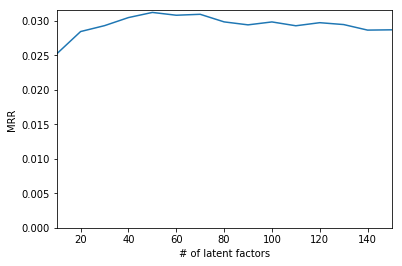

In [17]:
ax = psvd_rank_scores.plot(ylim=(0, None))
ax.set_xlabel('# of latent factors')
ax.set_ylabel(target_metric.upper());

## Scaled PureSVD model

We will employ a simple scaling trick over the rating matrix $R$ that was proposed by the authors of [EIGENREC model](https://arxiv.org/abs/1511.06033) [Nikolakopoulos2019]: $R \rightarrow RD^{f-1},$
where $D$ is a diagonal scaling matrix with elements corresponding to the norm of the matrix columns (or square root of the number of nonzero elements in each column for the binary case). Parameter $f$ controls the effect of scaling and typically lies in the range [0, 1]. Finding the optimal value is an experimental task and will be performed via grid-search. We will use built-in support for such model in Polara.

### Grid search

In [18]:
from polara.recommender.models import ScaledSVD
from polara.evaluation.pipelines import find_optimal_config # generic routine for grid-search

Now we have to compute SVD model for every value of $f$. However, we can still avoid computing the model for each rank value by the virtue of rank truncation.

In [19]:
def fine_tune_scaledsvd(model, ranks, scale_params, target_metric, config=None):
    rev_ranks = sorted(ranks, key=lambda x: -x) # descending order helps avoiding model recomputation
    param_grid = [(s1, r) for s1 in scale_params for r in rev_ranks]
    param_names = ('col_scaling', 'rank')
    return find_optimal_config(model,
                               param_grid,
                               param_names,
                               target_metric,
                               init_config=config,
                               return_scores=True,
                               force_build=False, # avoid recomputing the model
                               iterator=track)

We already know an approximate range of values for the scaling factor. You may also want to play with other values, especially when working with a different dataset.

In [20]:
ssvd = ScaledSVD(data_model) # create model
scaling = [0.2, 0.4, 0.6, 0.8]

ssvd_best_config, ssvd_scores = fine_tune_scaledsvd(ssvd,
                                                    rank_grid,
                                                    scaling,
                                                    target_metric,
                                                    config=init_config)

 [████████████████████████████████████████████████████████████] 60/60 [04:17<00:03, 4.29s/it]

Note that during this grid search the model was computed only `len(scaling)=4` number of times, other points were found via rank truncation. Let's see how quality changes with different values of scaling parameter $f$.

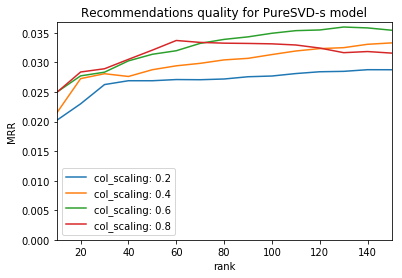

In [21]:
for cs in scaling:
    cs_scores = ssvd_scores.xs(cs, level='col_scaling')
    ax = cs_scores.plot(label=f'col_scaling: {cs}')
ax.set_title(f'Recommendations quality for {ssvd.method} model')
ax.set_ylim(0, None)
ax.set_ylabel(target_metric.upper())
ax.legend();

In [22]:
ssvd_rank_scores = ssvd_scores.xs(ssvd_best_config['col_scaling'], level='col_scaling')

The optimal set of hyper-parameters:

In [23]:
ssvd_best_config

{'col_scaling': 0.6, 'rank': 130}

## iALS

Using *implicit* library in Polara is almost as simple as using SVD-based models. Make sure you have it installed in your python environment (follow instructions at https://github.com/benfred/implicit ).

In [24]:
import os; os.environ["MKL_NUM_THREADS"] = "1" # as required by implicit
import numpy as np

from polara.recommender.external.implicit.ialswrapper import ImplicitALS
from polara.evaluation.pipelines import random_grid, set_config

### defining hyper-parameter grid

Hyper-parameter space in that case is much broader. We will start by adjusting all hyper-parameters expect the rank value and then, once an optimal config is found, we will perform full grid-search over the range of rank values defined by `rank_grid`.

In [25]:
als_params = dict(alpha = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
                  epsilon = [0.01, 0.03, 0.1, 0.3, 1],
                  weight_func = [None, np.sign, np.sqrt, np.log2, np.log10],
                  regularization = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3],
                  rank = [40] # enforce rank value for quick exploration of other parameters
                 )

In order to avoid too long computation time, grid-search is performed over 60 random points, which is enough to get within 5% of the optimum with 95% confidence [Bergstra]. The grid is generated with the built-in `random_grid` function.

In [26]:
als_param_grid, als_param_names = random_grid(als_params, n=60)

### random grid search 

In [27]:
ials = ImplicitALS(data_model) # create model

In [28]:
ials_best_config, ials_grid_scores = find_optimal_config(ials,
                                                         als_param_grid, # hyper-parameters grid
                                                         als_param_names, # hyper-parameters' names
                                                         target_metric,
                                                         init_config=init_config,
                                                         return_scores=True,
                                                         iterator=track)

 [████████████████████████████████████████████████████████████] 60/60 [24:14<00:24, 24.23s/it]

### rank tuning

In contrast to the case of SVD-based algorithms, iALS requires recomputing the model for every new rank value, therefore in addition to the previous 60 times, the model will be computed `len(rank_grid)` more times for all rank values.

In [29]:
ials_best_rank, ials_rank_scores = find_optimal_config(ials,
                                                       rank_grid,
                                                       'rank',
                                                       target_metric,
                                                       # configs are applied in the order they're provided
                                                       init_config=[init_config,
                                                                    ials_best_config],
                                                       return_scores=True,
                                                       iterator=track)

 [████████████████████████████████████████████████████████████] 15/15 [06:23<00:32, 25.56s/it]

Let's combine the best rank value with other optimal parameters:

In [30]:
ials_best_config.update(ials_best_rank)
ials_best_config

{'alpha': 1.0,
 'epsilon': 0.03,
 'weight_func': <ufunc 'sign'>,
 'regularization': 0.003,
 'rank': 60}

### visualizing rank tuning results

We can now see how all three algorithms compare to each other.

In [34]:
def plot_rank_scores(scores):
    ax = None
    for sc in scores:
        ax = sc.sort_index().plot(label=sc.name, ax=ax)
    ax.set_ylim(0, None)
    ax.set_title('Recommendations quality')
    ax.set_xlabel('# of latent factors')
    ax.set_ylabel(target_metric.upper());
    ax.legend()
    return ax

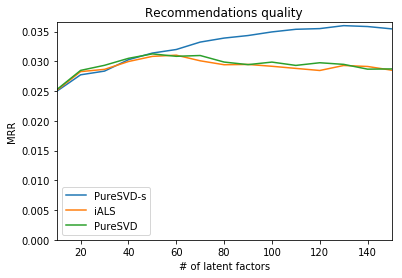

In [35]:
plot_rank_scores([ssvd_rank_scores,
                  ials_rank_scores,
                  psvd_rank_scores]);

It can be seen that scaling has a significant impact on the quality of recommendations. This is, however, a preliminary result, which is yet to be verified via cross-validation.

# Models comparison

The results above were computed only with a single split into train-test corresponding to a single fold. In order to verify the obtained results, perform a full CV with optimal parameters fixed. It can be achieved with the built-in `run_cv_experiment` function from Polara's evaluation engine as shown below.

## cross-validation experiment

In [36]:
from polara.evaluation import evaluation_engine as ee

Fixing optimal configurations:

In [53]:
set_config(psvd, {'rank': psvd_best_rank})
set_config(ssvd, ssvd_best_config)
set_config(ials, ials_best_config)

Performing 5-fold CV:

In [54]:
models = [psvd, ssvd, ials]
metrics = ['ranking', 'relevance', 'experience']

# run experiments silently
data_model.verbose = False
for model in models:
    model.verbose = False

# perform cross-validation on models, report scores according to metrics
cv_results = ee.run_cv_experiment(models,
                                  metrics=metrics,
                                  iterator=track)

 [████████████████████████████████████████████████████████████] 5/5 [04:15<00:51, 50.93s/it]

The output contains results for all folds:

In [55]:
cv_results.head()

type           relevance   ranking experience
metric                hr       mrr   coverage
fold model                                   
1    PureSVD    0.076857  0.029101   0.085902
     PureSVD-s  0.084729  0.032221   0.148946
     iALS       0.073780  0.027274   0.089461
2    PureSVD    0.079868  0.029385   0.089836
     PureSVD-s  0.086953  0.034059   0.150539

## plotting results

We will plot average scores and confidence intervals for them. The following function will do this based on raw input from CV:

In [56]:
def plot_cv_results(scores, subplot_size=(6, 3.5)):
    scores_mean = scores.mean(level='model')
    scores_errs = ee.sample_ci(scores, level='model')
    # remove top-level columns with classes of metrics (for convenience)
    scores_mean.columns = scores_mean.columns.get_level_values(1)
    scores_errs.columns = scores_errs.columns.get_level_values(1)
    # plot results
    n = len(scores_mean.columns)
    return scores_mean.plot.bar(yerr=scores_errs, rot=0,
                                subplots=True, layout=(1, n),
                                figsize=(subplot_size[0]*n, subplot_size[1]),
                                legend=False);

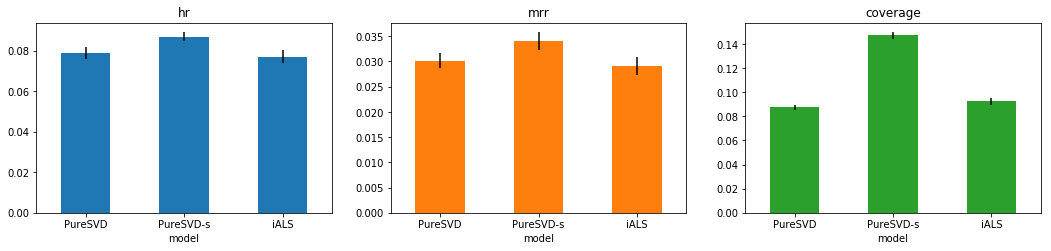

In [57]:
plot_cv_results(cv_results);

The difference between PureSVD and iALS is not significant. In contrast, the advantage of the scaled version of PureSVD denoted as `PureSVD-s` over the other models is much more pronounced making it a clear favorite. Interestingly, the difference is especially pronounced in terms of the `coverage` metric, which is defined as the ratio of unique recommendations generated for all test users to the total number of items in the training data.  This indicates that generated recommendations are not only more relevant but also are significantly more diverse. 

## comparing training time

Another important practical aspect is how long does it take to compute a model? Sometimes the best model in terms of quality of recommendations can be the slowest to compute. You can check each model's training time by accessing the `training_time` list attribute. It holds the history of trainings, hence, if you have just performed 5-fold CV experiment, the last 5 entries in this list will correspond to the training time on each fold. This information can be used to get average time with some error bounds as shown below.

In [58]:
import pandas as pd

In [59]:
timings = {}
for model in models:
    timings[f'{model.method} rank {model.rank}'] = model.training_time[-5:]

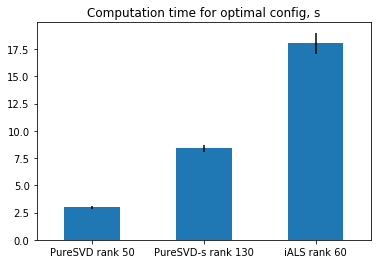

In [60]:
time_df = pd.DataFrame(timings)
time_df.mean().plot.bar(yerr=time_df.std(), rot=0, title='Computation time for optimal config, s');

`PureSVD-s` compares favoribly to the iALS, even though it requires higher rank value, which results in a longer training time comparing to `PureSVD`. Another interesting measure is what time does it take to achieve approximately the same quality by all models. 
Note that all models give approximately the same quality at the optimal rank of iALS. Let's compare training time for this value of rank.

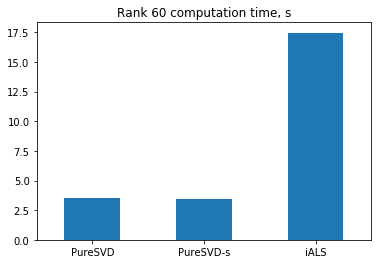

In [61]:
fixed_rank_timings = {}
for model in models:
    model.rank = ials_best_config['rank']
    model.build()
    fixed_rank_timings[model.method] = model.training_time[-1]

pd.Series(fixed_rank_timings).plot.bar(rot=0, title=f'Rank {ials.rank} computation time, s')

By all means computing SVD on this dataset is much faster than ALS. This may, however, vary on other datasets due to a different sparsity structure. Nevertheless, you can still expect, that SVD-based models will be perfroming well due the usage of to highly optimized BLAS and LAPACK routines.

# Bonus: scaling for iALS

You may reasonably question whether that scaling trick also works for non SVD-based models. Let's verify its applicability for iALS. We will reuse Polara's built-in scaling functions in order to create a new class of the *scaled iALS-based model*.

In [62]:
from polara.recommender.models import ScaledMatrixMixin

In [63]:
class ScaledIALS(ScaledMatrixMixin, ImplicitALS): pass # similarly to how PureSVD is extended to its scaled version

In [64]:
sals = ScaledIALS(data_model)

In order to save time, we will utilize the optimal configuration for scaling, found by tuning scaled version of PureSVD. Alternatively, you could include scaling parameters into the grid search step by extending `als_param_grid` and `als_param_names` variables. However, taking configuration of PureSVD-s should be a good enough approximation at least for verifying the effect of scaling. The tuning itself has to be repeated from the beginning.

### hyper-parameter tuning

In [65]:
sals_best_config, sals_param_scores = find_optimal_config(sals,
                                                          als_param_grid,
                                                          als_param_names,
                                                          target_metric,
                                                          init_config=[init_config,
                                                                       ssvd_best_config], # the rank value will be overriden
                                                          return_scores=True,
                                                          iterator=track)

 [████████████████████████████████████████████████████████████] 60/60 [22:42<00:24, 22.70s/it]

In [66]:
sals_best_rank, sals_rank_scores = find_optimal_config(sals,
                                                       rank_grid,
                                                       'rank',
                                                       target_metric,
                                                       init_config=[init_config,
                                                                    ssvd_best_config,
                                                                    sals_best_config],
                                                       return_scores=True,
                                                       iterator=track)

 [████████████████████████████████████████████████████████████] 15/15 [07:03<00:39, 28.18s/it]

### visualizing rank tuning results

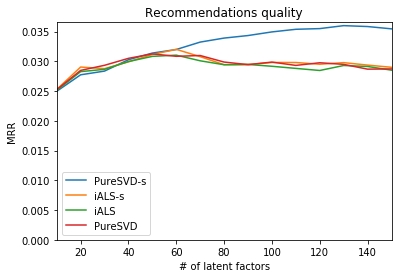

In [67]:
plot_rank_scores([ssvd_rank_scores,
                  sals_rank_scores,
                  ials_rank_scores,
                  psvd_rank_scores]);

There seem to be no difference between the original and scaled versions of iALS. Let's verify this with CV experiment.

### cross-validation

You only need to perform CV computations for the new model. Configuration of data will be the same as previously, as the `data_model` instance ensures reproducible data state.

In [68]:
sals_best_config.update(sals_best_rank)
sals_best_config

{'alpha': 0.3,
 'epsilon': 0.1,
 'weight_func': <ufunc 'log2'>,
 'regularization': 1.0,
 'rank': 60}

In [69]:
set_config(sals, sals_best_config)

In [70]:
sals.verbose = False
sals_cv_results = ee.run_cv_experiment([sals],
                                       metrics=metrics,
                                       iterator=track)

 [████████████████████████████████████████████████████████████] 5/5 [03:00<00:36, 36.06s/it]

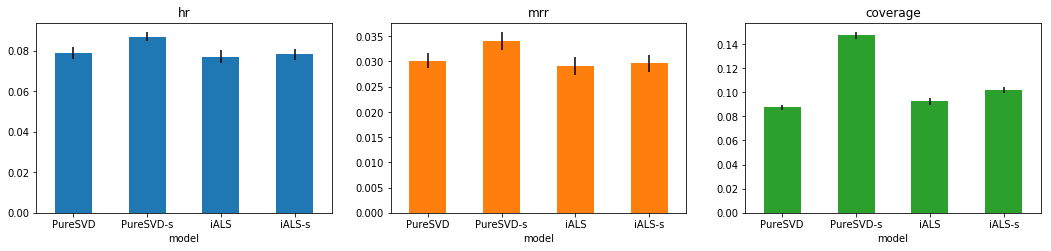

In [72]:
plot_cv_results(cv_results.append(sals_cv_results));

Surprisingly, the iALS model remains largely insensitive to the scaling trick. At least in the current settings and for the current dataset.  
**Remark**: You may want to repeat all experiments in a different setting with `random_holdout` set to `True`. My own results indicate that in this case iALS becomes more responsive to scaling and gives the same result as the scaled version of SVD. However, SVD is still much easier to compute and tune.

# Conclusion

With a proper tuning the quality of recommendations of one of the simplest SVD-based models can be substantially improved. Despite common beliefs, it turns out that PureSVD with simple scaling trick compares favorably to a much more popular iALS algorithm. It not only generates more relevant recommendations, but also makes them more diverse and potentially more interesting. In addition to that it has a number of unique advantages and merely requires to simply do `from scipy.sparse.linalg import svds` to start using it. Of course, the obtained results may not necessarily hold on all other datasets and require further verification. However, in the view of all its features, the scaled SVD-based model can be certainly considered as at least one of the default baseline candidates. The result obtained here resembles situation in the Natural Language Processing field, where simple SVD-based model with proper tuning [turns out to be competitive](http://www.aclweb.org/anthology/Q15-1016) on a variety of downstream tasks even in comparison with Neural Network-based models. In the end it's all about fair comparison.

As a final remark, Polara is designed to support opennes and reproducibility of research. It allows to perform thorough experiments with minimal efforts. It can be used to quickly test known ideas or implement something new by providing controlled environment and rich functionality with high level abstractions.